In [3]:
import sys
sys.path.append('/Users/Device6/Documents/Research/bgoodlab/microbiome_evolution/')

In [4]:
import pandas as pd
import numpy as np
import os

from utils import sample_utils, core_gene_utils, diversity_utils, parallel_utils, close_pair_utils
import config

In [5]:
import matplotlib.pyplot as plt
import matplotlib as mpl

## making a few final figures

In [4]:
species_name = 'MGYG-HGUT-02478'
save_path = os.path.join(config.analysis_directory, "closely_related", "isolates", "%s_all_transfers_dedup.csv" % species_name)

dedup_events = pd.read_csv(save_path)
core_mask = parallel_utils.get_general_site_mask(species_name, allowed_variants=['1D', '2D', '3D', '4D'])
#     syn_core_mask = dh.general_mask
syn_core_mask = parallel_utils.get_general_site_mask(species_name, allowed_variants=['4D'])
full_to_syn_mask = syn_core_mask[core_mask]  # core -> 4D core
syn_core_length = syn_core_mask.sum()
full_coord_to_syn_coord = np.empty(shape=full_to_syn_mask.shape)
full_coord_to_syn_coord[full_to_syn_mask] = np.arange(syn_core_length).astype(int)
full_coord_to_syn_coord[~full_to_syn_mask] = -1  # sites not in syn core

close_pair_pileup_dedup = np.zeros(syn_core_length)

for i, row in dedup_events.iterrows():
    start = row['Core genome start loc']
    end = row['Core genome end loc']
    syn_core_start = int(full_coord_to_syn_coord[start])
    syn_core_end = int(full_coord_to_syn_coord[end])
    close_pair_pileup_dedup[syn_core_start:syn_core_end+1] += 1

# now loading typical pair pile up
ckpt_path = os.path.join(config.analysis_directory, 'sharing_pileup', 'isolates')
cumu_runs = np.loadtxt(os.path.join(ckpt_path, '{}.csv'.format(species_name)))

In [5]:
dh = parallel_utils.DataHoarder(species_name, mode='isolates', allowed_variants=['4D'])

Keeping only isolate samples, which is 100 in total


In [5]:
# three rnd genes
gene1739_region = 2275346, 2276428
gene1740_region =2276436, 2279651
gene1741_region =2279648, 2281021
region_start, region_end = 2275346, 2281021
ref_to_syn_core = np.zeros(syn_core_mask.shape) - 1
ref_to_syn_core[syn_core_mask] = np.arange(syn_core_mask.sum())

region_coords = ref_to_syn_core[region_start:region_end]
region_coords = region_coords[region_coords>=0]

In [6]:
cp_pileup = close_pair_pileup_dedup

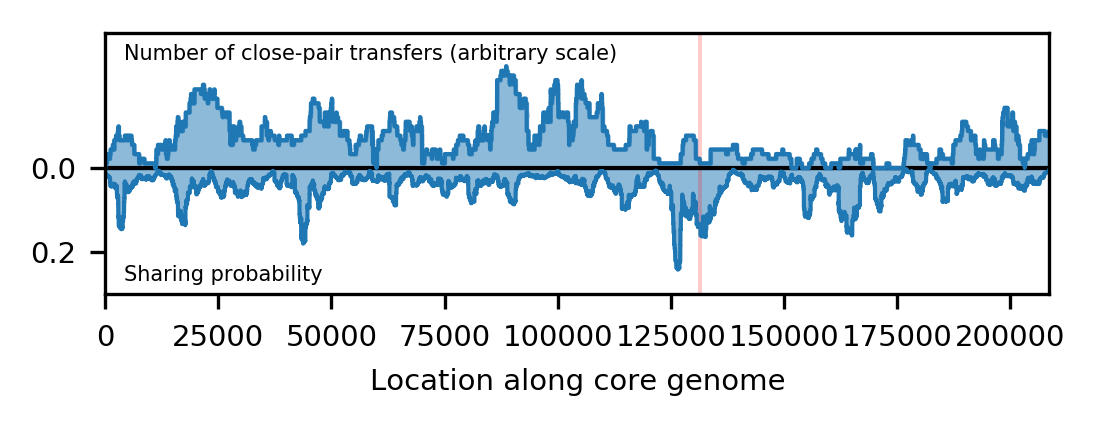

In [7]:
mpl.rcParams['font.size'] = 7
mpl.rcParams['lines.linewidth'] = 0.5
# mpl.rcParams['legend.frameon'] = False
mpl.rcParams['legend.fontsize'] = 'small'

fig, ax = plt.subplots(figsize=(7*0.58, 4.8 * 0.24), dpi=300)
colors=['tab:blue', 'tab:orange']

scale_factor = cp_pileup.max() / cumu_runs[:, 0].max()
ax.plot(cp_pileup / scale_factor, linewidth=1, color=colors[0])
xs = np.arange(cp_pileup.shape[0])
zeros = np.zeros(cp_pileup.shape[0])
ax.fill_between(xs, zeros, cp_pileup / scale_factor, color=colors[0], alpha=0.5, rasterized=True)

ax.plot(-cumu_runs[:, 0], linewidth=1)
ax.fill_between(xs, -cumu_runs[:, 0], zeros, alpha=0.5, rasterized=True)

ax.hlines(0, 0, cumu_runs.shape[0], 'black', linewidth=1)
ax.set_xlim([0, cumu_runs.shape[0]])
ax.set_xlabel("Location along core genome")
ax.set_yticks([0, -0.2])
ax.set_yticklabels(np.around(map(np.abs, ax.get_yticks()), decimals=1))

ax.text(0.02, 0.9, "Number of close-pair transfers (arbitrary scale)", transform=ax.transAxes, fontsize=5)
ax.text(0.02, 0.05, "Sharing probability", transform=ax.transAxes, fontsize=5)

ax.set_ylim([-0.3, 0.32])

plt.axvspan(region_coords.min(), region_coords.max(), linewidth=0, color='red', alpha=0.2)
fig.savefig(os.path.join(config.figure_directory, 'isolates', 'Bv_pileup_compare.pdf'), bbox_inches='tight')

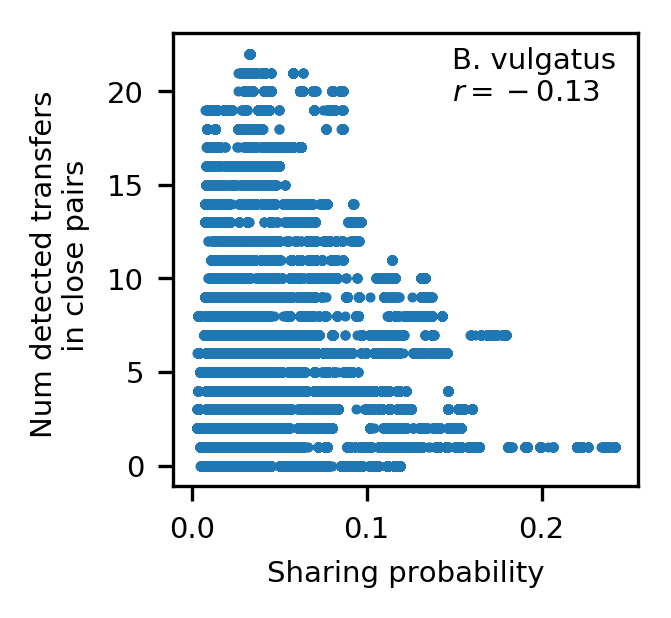

In [8]:
mpl.rcParams['font.size'] = 7
mpl.rcParams['lines.linewidth'] = 0.5
# mpl.rcParams['legend.frameon'] = False
mpl.rcParams['legend.fontsize'] = 'small'

fig, ax = plt.subplots(figsize=(2, 2), dpi=300)
ax.scatter(cumu_runs[:, 0], cp_pileup, s=2, rasterized=True)
ax.set_xlabel('Sharing probability')
ax.set_ylabel('Num detected transfers \n in close pairs')
corr = np.corrcoef(cumu_runs[:, 0], cp_pileup)[0, 1]
ax.text(0.6, 0.85, "B. vulgatus \n$r={0:.2f}$".format(corr), transform=ax.transAxes,)
fig.savefig(os.path.join(config.figure_directory, 'isolates', 'Bv_pileup_compare_cvs.pdf'), bbox_inches='tight')

In [11]:
isolate_metadata = pd.read_csv(os.path.join(config.isolate_directory, 'isolate_info.csv'), index_col='MGnify_accession')
len_res = []
for species_name, row in isolate_metadata.iterrows():
    # different version of the above using dedup-ed events
    save_path = os.path.join(config.analysis_directory, "closely_related", "isolates", "%s_all_transfers_dedup.csv" % species_name)
    if not os.path.exists(save_path):
        print("Intermediate file not found for {}, skipping".format(species_name))
        continue
        
    if '2478' in species_name:
        transfer_df = pd.read_pickle(os.path.join(config.analysis_directory, "closely_related", "isolates", "%s_all_transfers.pickle" % 'MGYG-HGUT-02478'))
        transfer_df = transfer_df[transfer_df['clonal fraction']>0.8]
        within_transfers = transfer_df[transfer_df['types']==0]['transfer lengths (core genome)']
        between_transfers = transfer_df[transfer_df['types']==1]['transfer lengths (core genome)']
        len_res.append(('Bacteroides vulgatus\n(within clade)', within_transfers))
        len_res.append(('Bacteroides vulgatus\n(between clade)', between_transfers))
        continue
    transfer_df = pd.read_csv(save_path)
    transfer_df = transfer_df[transfer_df['Clonal fraction']>0.8]
    transfer_len = transfer_df['Transfer length (# covered sites on core genome)']
    len_res.append((species_name, transfer_len))
    print(species_name, np.mean(transfer_len), np.median(transfer_len))

('MGYG-HGUT-01346', 9465.68438538206, 6572.0)
('MGYG-HGUT-02438', 8109.472222222223, 5127.5)
('MGYG-HGUT-01337', 13797.9, 10471.5)
('MGYG-HGUT-01378', 7899.827731092437, 5048.5)
Intermediate file not found for MGYG-HGUT-02492, skipping
Intermediate file not found for MGYG-HGUT-03681, skipping
Intermediate file not found for MGYG-HGUT-00196, skipping
Intermediate file not found for MGYG-HGUT-01345, skipping
Intermediate file not found for MGYG-HGUT-02549, skipping
('MGYG-HGUT-02422', 9309.170987856909, 7032.0)
('MGYG-HGUT-02538', 63315.74324324324, 35480.5)
('MGYG-HGUT-02366', 6786.462406015037, 694.0)
('MGYG-HGUT-02331', 7557.59437751004, 3418.0)


In [12]:
species_list = ['Bacteroides vulgatus\n(within clade)', 'Bacteroides vulgatus\n(between clade)', 'Bacteroides uniformis', 'Parabacteroides distasonis', 'Bacteroides fragilis', 'Bacteroides ovatus']

In [13]:
fig3_data = pd.read_csv(os.path.join(config.analysis_directory, 'misc', 'fig3_transfer_length.csv'))

In [14]:
fig3_data = fig3_data.set_index('Species name').loc[species_list]

In [15]:
fig3_data

,Unnamed: 0,Median length (bp),Mean length (bp)
Species name,,,
Bacteroides vulgatus\n(within clade),0,13788.5,24186.447000
Bacteroides vulgatus\n(between clade),1,1889.5,4278.425373
Bacteroides uniformis,3,4111.0,6219.005000
Parabacteroides distasonis,14,5348.5,8021.280000
Bacteroides fragilis,11,8716.5,11721.878000
Bacteroides ovatus,2,5765.0,7355.889000


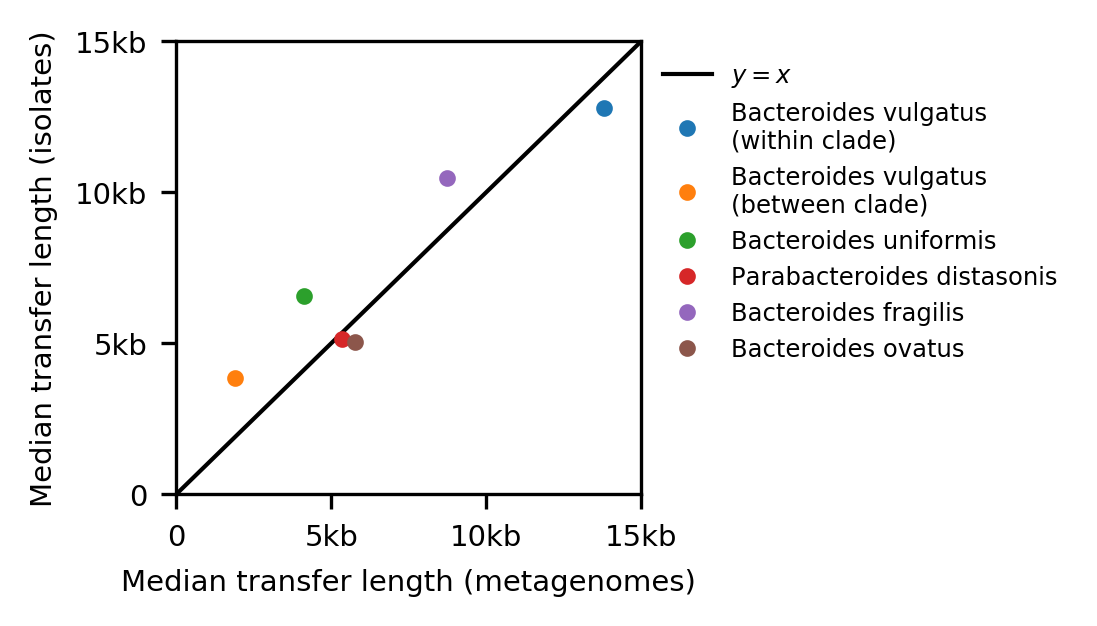

In [18]:
mpl.rcParams['font.size'] = 7
mpl.rcParams['lines.linewidth'] = 1
mpl.rcParams['legend.frameon'] = False
mpl.rcParams['legend.fontsize'] = 'small'

fig, ax = plt.subplots(figsize=(2, 2), dpi=300)
isolate_medians = []
xs = np.linspace(0, 15000)
ax.plot(xs, xs, 'k', label='$y=x$')

for i in range(6):
    isolate_medians.append(np.median(len_res[i][1]))
    ax.plot(fig3_data.iloc[i, 1], isolate_medians[-1], '.', label=species_list[i])

ax.legend(bbox_to_anchor=(1, 1))
ax.set_xlim([0, 15000])
ax.set_ylim([0, 15000])
ax.set_yticks(ax.get_xticks())
ax.set_xticklabels(['0', '5kb', '10kb', '15kb'])
ax.set_yticklabels(['0', '5kb', '10kb', '15kb'])
ax.set_xlabel('Median transfer length (metagenomes)')
ax.set_ylabel('Median transfer length (isolates)')
fig.savefig(os.path.join(config.figure_directory, 'isolates', 'transfer_len_compare.pdf'), bbox_inches='tight')

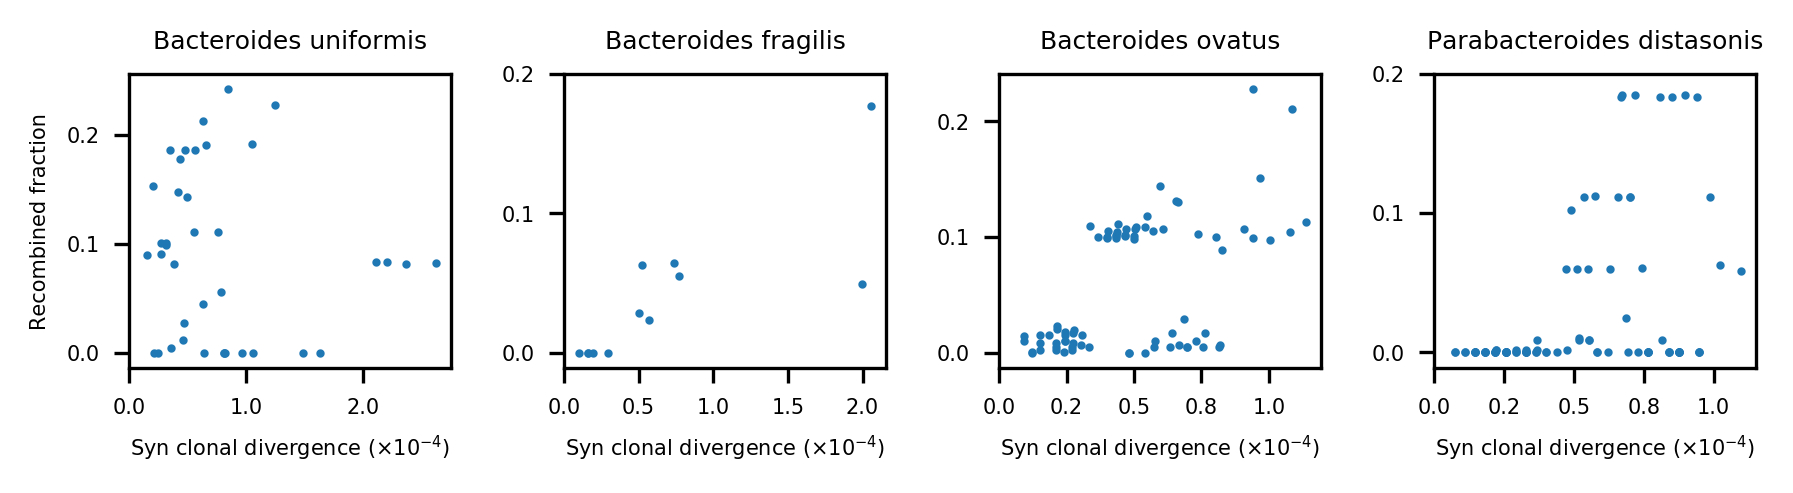

In [19]:
mpl.rcParams['font.size'] = 5
mpl.rcParams['lines.linewidth'] = 1
mpl.rcParams['legend.frameon'] = False
mpl.rcParams['legend.fontsize'] = 'small'

fig, axes = plt.subplots(1, 4, figsize=(7, 1.3), dpi=300)
plt.subplots_adjust(wspace=0.35)

species_to_plot = ['MGYG-HGUT-01346', 'MGYG-HGUT-01337', 'MGYG-HGUT-01378', 'MGYG-HGUT-02438']
for i in range(4):
    species_name = species_to_plot[i]
    raw_data = pd.read_pickle(os.path.join(config.analysis_directory, 'closely_related', 'isolates', species_name + '_thirdpass.pickle'))
    x_, y_, cf_mask = close_pair_utils.prepare_x_y(raw_data, return_unfiltered=True, mode='fraction')
    x = x_[cf_mask]
    y = y_[cf_mask]

    axes[i].scatter(x, y, s=1)
    axes[i].set_xlim([0, max(x)*1.05])
    axes[i].set_yticks([0, 0.1, 0.2])
    axes[i].set_title(isolate_metadata.loc[species_name, 'Species'])
#     axes[i].ticklabel_format(axis='x', style='sci', scilimits=(0, 0))
    axes[i].set_xticklabels(["%.1f"%(x * 1e4) for x in axes[i].get_xticks()])
    axes[i].set_xlabel('Syn clonal divergence 'r'($\times 10^{-4}$)')
axes[0].set_ylabel("Recombined fraction")
fig.savefig(os.path.join(config.figure_directory, 'isolates', 'recomb_frac_commensals.pdf'), bbox_inches='tight')

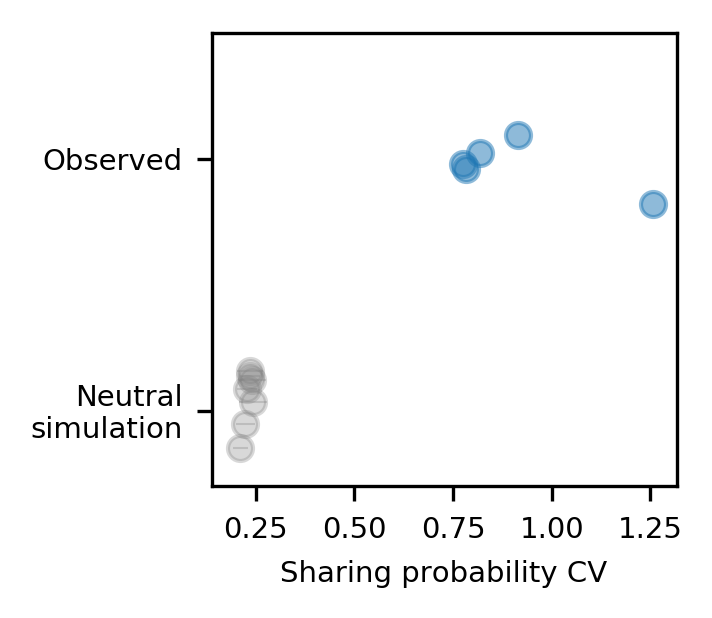

In [10]:
species_to_plot = ['MGYG-HGUT-02478', 'MGYG-HGUT-01346', 'MGYG-HGUT-01337', 'MGYG-HGUT-01378', 'MGYG-HGUT-02438']
fig, ax = plt.subplots(figsize=(2, 2), dpi=300)
cvs = []
for i in range(5):
    species_name = species_to_plot[i]
    ckpt_path = os.path.join(config.analysis_directory, 'sharing_pileup', 'isolates')
    cumu_runs = np.loadtxt(os.path.join(ckpt_path, '{}.csv'.format(species_name)))
    sharing_pileup = cumu_runs[:, 0]
    cv = np.std(sharing_pileup, axis=0) / np.mean(sharing_pileup, axis=0)
    cvs.append(cv)

sim_cvs = np.loadtxt(os.path.join(config.analysis_directory, 'sharing_pileup', 'simulated', 'r_scan_statistics', 'cvs.csv'))
sim_cvs = sim_cvs.reshape((-1, 100))
mean_sim_cvs = sim_cvs.mean(axis=1)
sigma_sim_cvs = np.std(sim_cvs, axis=1)

ax.scatter(cvs, np.ones(len(cvs)) + np.random.uniform(-0.2, 0.2, size=len(cvs)), marker='o', alpha=0.5)

ax.errorbar(mean_sim_cvs, np.zeros(mean_sim_cvs.shape) + np.random.uniform(-0.2, 0.2, size=mean_sim_cvs.shape), xerr=sigma_sim_cvs, fmt='o', color='grey', alpha=0.3)

ax.set_yticks([0, 1])
ax.set_ylim([-0.3, 1.5])
ax.set_yticklabels(['Neutral\nsimulation', 'Observed'])
ax.set_xlabel('Sharing probability CV')
fig.savefig(os.path.join(config.figure_directory, 'isolates', 'pileup_cvs.pdf'), bbox_inches='tight')

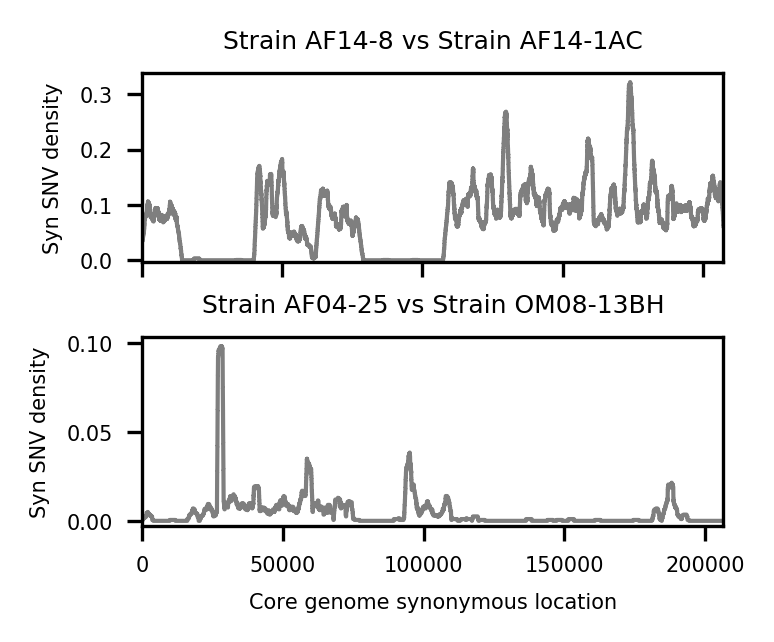

In [21]:
mpl.rcParams['font.size'] = 5
mpl.rcParams['lines.linewidth'] = 1
mpl.rcParams['legend.frameon'] = False
mpl.rcParams['legend.fontsize'] = 'small'

snp_vec = np.loadtxt(os.path.join(config.plotting_intermediate_directory, "Bv_cached_close_pair_isolates_1.csv"))
window_size = 2000
local_pi = np.convolve(snp_vec, np.ones(window_size) / float(window_size), mode='same')

fig, axes = plt.subplots(2, 1, figsize=(2.5, 2), dpi=300)
plt.subplots_adjust(hspace=0.4)

axes[0].set_title("Strain {} vs Strain {}".format('AF14-8', 'AF14-1AC'))
axes[0].plot(local_pi, color='tab:grey')
# ax.set_yticks((0.0, 0.04, 0.08))
# ax.set_ylim(-0.001, 0.085)
axes[0].set_xlim([0, len(snp_vec)])
axes[0].set_ylim(ymin=-0.003)
axes[0].set_ylabel('Syn SNV density')
axes[0].set_xticks([0, 50000, 100000, 150000, 200000])
axes[0].set_xticklabels([])


snp_vec = np.loadtxt(os.path.join(config.plotting_intermediate_directory, "Bv_cached_close_pair_isolates_2.csv"))
window_size = 2000
local_pi = np.convolve(snp_vec, np.ones(window_size) / float(window_size), mode='same')
axes[1].set_title("Strain {} vs Strain {}".format('AF04-25', 'OM08-13BH'))
axes[1].plot(local_pi, color='tab:grey')
# ax.set_yticks((0.0, 0.04, 0.08))
# ax.set_ylim(-0.001, 0.085)
axes[1].set_xlim([0, len(snp_vec)])
axes[1].set_ylim(ymin=-0.003)
axes[1].set_ylabel('Syn SNV density')
axes[1].set_xticks([0, 50000, 100000, 150000, 200000])

axes[1].set_xlabel("Core genome synonymous location")
fig.savefig(os.path.join(config.figure_directory, 'isolates', 'Bv_long_transfers.pdf'), bbox_inches='tight')

Text(0.5,0,'Core genome synonymous location')

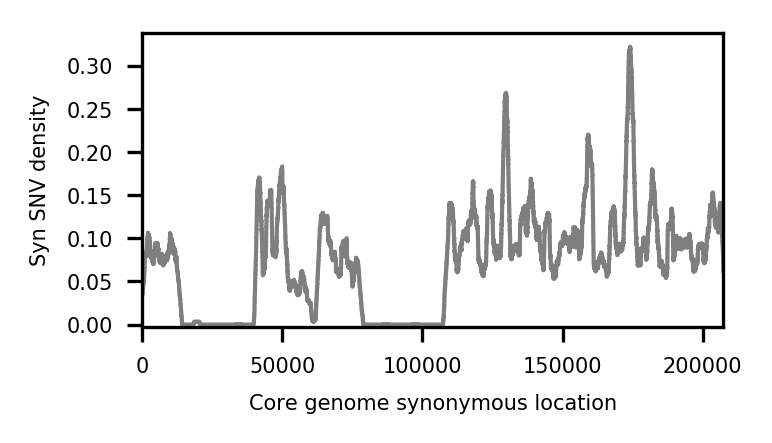

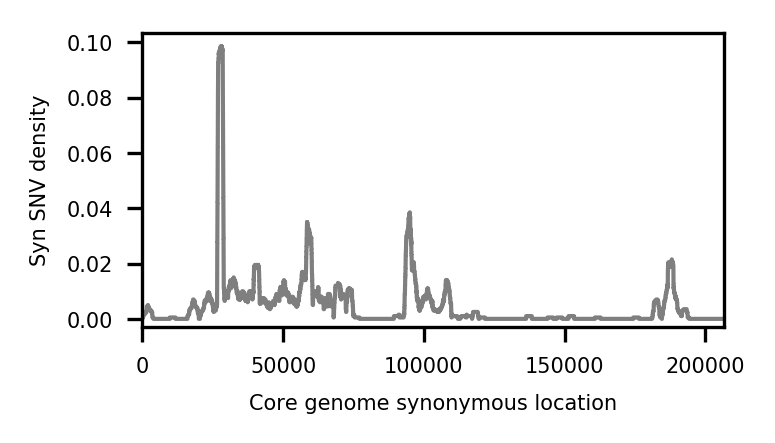

In [207]:
snp_vec, _ = dh.get_snp_vector([15, 16])
np.savetxt(os.path.join(config.plotting_intermediate_directory, "Bv_cached_close_pair_isolates_1.csv"), snp_vec)

window_size = 2000
local_pi = np.convolve(snp_vec, np.ones(window_size) / float(window_size), mode='same')

fig, ax = plt.subplots(figsize=(2.5, 1.3), dpi=300)
# ax.set_title("Strain {} vs Strain {}".format('AF14-8', 'AF14-1AC'))
ax.plot(local_pi, color='tab:grey')
# ax.set_yticks((0.0, 0.04, 0.08))
# ax.set_ylim(-0.001, 0.085)
ax.set_xlim([0, len(snp_vec)])
ax.set_ylim(ymin=-0.003)
ax.set_ylabel('Syn SNV density')
ax.set_xticks([0, 50000, 100000, 150000, 200000])
ax.set_xlabel("Core genome synonymous location")

snp_vec, _ = dh.get_snp_vector([12, 83])
np.savetxt(os.path.join(config.plotting_intermediate_directory, "Bv_cached_close_pair_isolates_2.csv"), snp_vec)

window_size = 2000
local_pi = np.convolve(snp_vec, np.ones(window_size) / float(window_size), mode='same')

fig, ax = plt.subplots(figsize=(2.5, 1.3), dpi=300)
# ax.set_title("Strain {} vs Strain {}".format('AF14-8', 'AF14-1AC'))
ax.plot(local_pi, color='tab:grey')
# ax.set_yticks((0.0, 0.04, 0.08))
# ax.set_ylim(-0.001, 0.085)
ax.set_xlim([0, len(snp_vec)])
ax.set_ylim(ymin=-0.003)
ax.set_ylabel('Syn SNV density')
ax.set_xticks([0, 50000, 100000, 150000, 200000])
ax.set_xlabel("Core genome synonymous location")

## finally, pathogen final figures

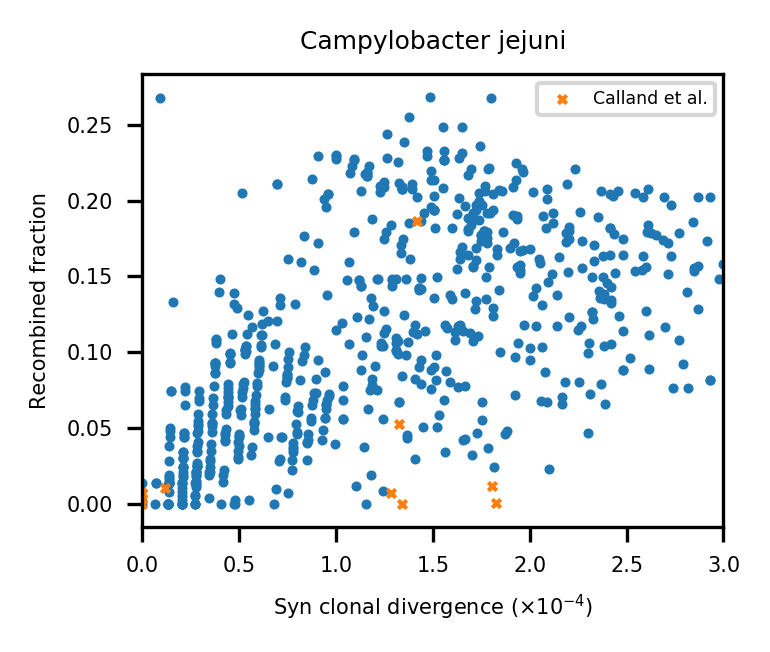

In [22]:
third_pass_path = os.path.join(config.analysis_directory, "closely_related", 'isolates', "{}_thirdpass.pickle".format('MGYG-HGUT-02422'))
third_pass_df = pd.read_pickle(third_pass_path)
transfer_path = os.path.join(config.analysis_directory, "closely_related", 'isolates', "{}_all_transfers.pickle".format('MGYG-HGUT-02422'))
transfer_df = pd.read_pickle(transfer_path)

path = os.path.join(config.plotting_intermediate_directory, 'Calland_etal.csv')
calland_df = pd.read_csv(path)
syn_snp = calland_df.loc[:, 'S_clonal']
syn_genome_len = calland_df['Genome length (bp)'].apply(lambda x: x.replace(',', '')).astype(int) / 9.05  # translate full genome length to 4D genome length using conversion factor found in uhgg isolates
syn_divergence = syn_snp / syn_genome_len
human_mask = calland_df['Source']=='Human'
x = syn_divergence
y = calland_df['% of recombined genome'] / 100
calland_x = x[human_mask]
calland_y = y[human_mask]

fig, ax = plt.subplots(1, 1, figsize=(2.5, 2), dpi=300)

x = third_pass_df['clonal divs']
y = 1 - third_pass_df['clonal fractions']
x_ = x[x > 0]
y_ = y[x > 0]
rates = y_ / x_
ax.scatter(x, y, s=2, label=None)
ax.scatter(calland_x, calland_y, s=4, marker='x', label='Calland et al.')
ax.set_xlim([0, 3e-4])

ax.set_xticklabels(["%.1f"%(x * 1e4) for x in ax.get_xticks()])
ax.set_xlabel('Syn clonal divergence 'r'($\times 10^{-4}$)')
ax.legend(frameon=True)
ax.set_ylabel("Recombined fraction")

ax.set_title(isolate_metadata.loc['MGYG-HGUT-02422', 'Species'], fontsize=6)
fig.savefig(os.path.join(config.figure_directory, 'isolates', 'Cj_recomb_frac.pdf'), bbox_inches='tight')

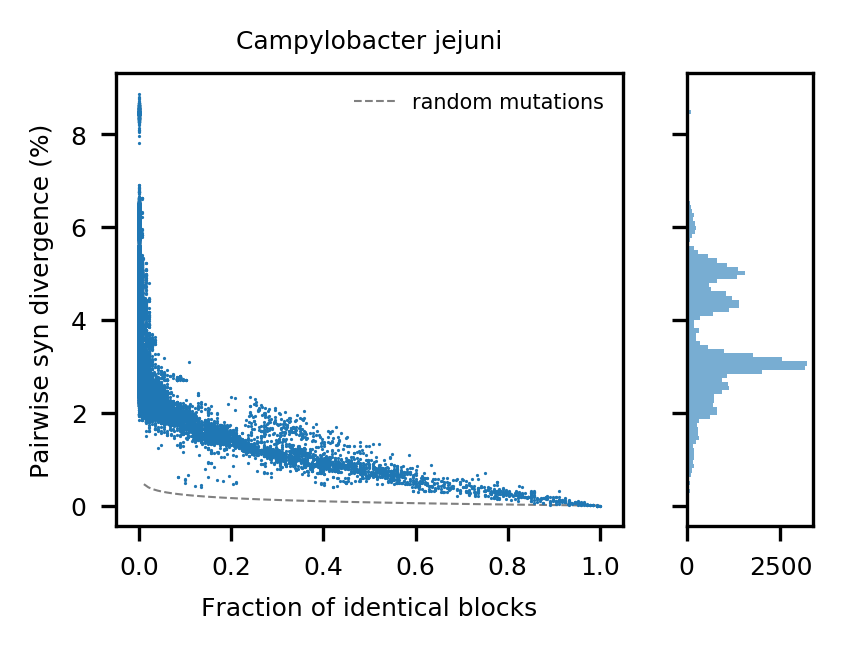

In [27]:
from utils import typical_pair_utils
import matplotlib.gridspec as gridspec

fig, ax = plt.subplots(figsize=(3, 2), dpi=300)
inner_grid = gridspec.GridSpecFromSubplotSpec(1,2, width_ratios=[4,1],wspace=0.2,subplot_spec=ax)
scatter_ax = fig.add_subplot(inner_grid[0])
marg_ax = fig.add_subplot(inner_grid[1], sharey=scatter_ax)

plt.setp(marg_ax.get_yticklabels(), visible=False)
plt.setp(marg_ax.get_yticklabels(minor=True), visible=False)

species_name = 'MGYG-HGUT-02422'
x,y = typical_pair_utils.get_joint_plot_x_y(species_name)
y = y * 100

xs = np.linspace(0.01, 1, 100)
ys = -np.log(xs) / config.first_pass_block_size * 100
scatter_ax.plot(xs, ys, '--', color='grey', zorder=1, label='random mutations')

scatter_ax.scatter(x, y, s=0.6, linewidth=0, zorder=2, rasterized=True)
marg_ax.hist(y, orientation='horizontal', bins=100, alpha=0.6)

# marg_ax.set_xscale('log')

scatter_ax.set_xlabel('Fraction of identical blocks')
scatter_ax.set_ylabel('Pairwise syn divergence (%)')
scatter_ax.legend()
scatter_ax.set_title(isolate_metadata.loc['MGYG-HGUT-02422', 'Species'], fontsize=6)
fig.delaxes(ax)
fig.savefig(os.path.join(config.figure_directory, 'isolates', 'Cj_join_dist.pdf'), bbox_inches='tight')

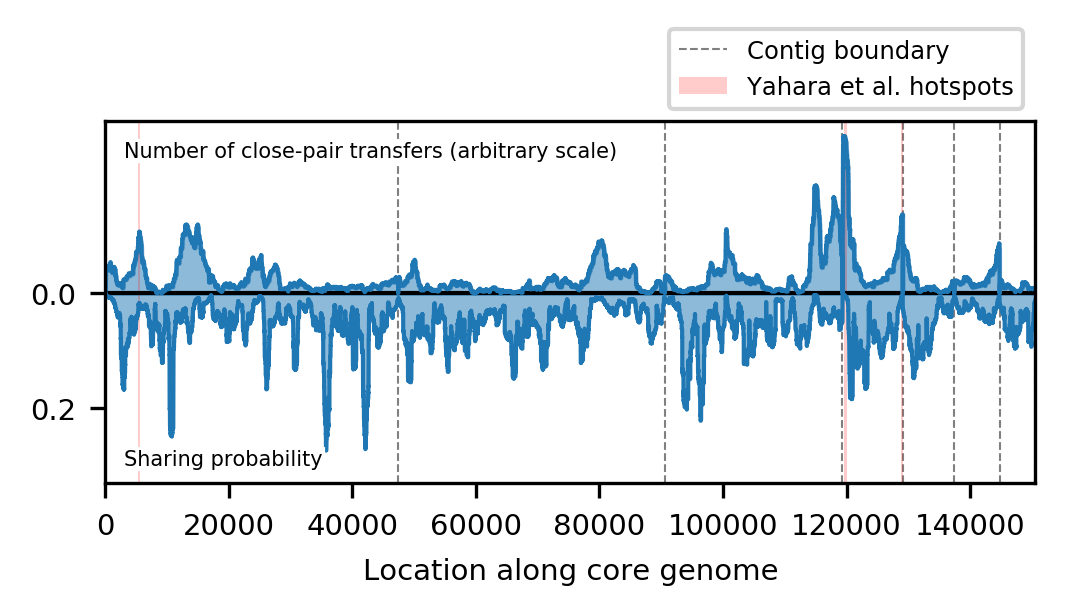

In [11]:
species_name = 'MGYG-HGUT-02422'
save_path = os.path.join(config.analysis_directory, "closely_related", "isolates", "%s_all_transfers_dedup.csv" % species_name)

dedup_events = pd.read_csv(save_path)
core_mask = parallel_utils.get_general_site_mask(species_name, allowed_variants=['1D', '2D', '3D', '4D'])
#     syn_core_mask = dh.general_mask
syn_core_mask = parallel_utils.get_general_site_mask(species_name, allowed_variants=['4D'])
full_to_syn_mask = syn_core_mask[core_mask]  # core -> 4D core
syn_core_length = syn_core_mask.sum()
full_coord_to_syn_coord = np.empty(shape=full_to_syn_mask.shape)
full_coord_to_syn_coord[full_to_syn_mask] = np.arange(syn_core_length).astype(int)
full_coord_to_syn_coord[~full_to_syn_mask] = -1  # sites not in syn core
ref_to_syn_core = np.zeros(len(syn_core_mask)) - 1
ref_to_syn_core[syn_core_mask] = np.arange(syn_core_mask.sum())

close_pair_pileup_dedup = np.zeros(syn_core_length)

for i, row in dedup_events.iterrows():
    start = row['Core genome start loc']
    end = row['Core genome end loc']
    syn_core_start = int(full_coord_to_syn_coord[start])
    syn_core_end = int(full_coord_to_syn_coord[end])
    close_pair_pileup_dedup[syn_core_start:syn_core_end+1] += 1
cp_pileup = close_pair_pileup_dedup
# now loading typical pair pile up
ckpt_path = os.path.join(config.analysis_directory, 'sharing_pileup', 'isolates')
cumu_runs = np.loadtxt(os.path.join(ckpt_path, '{}.csv'.format(species_name)))

mpl.rcParams['font.size'] = 7
mpl.rcParams['lines.linewidth'] = 0.5
# mpl.rcParams['legend.frameon'] = False
mpl.rcParams['legend.fontsize'] = 'small'

fig, ax = plt.subplots(figsize=(4, 1.6), dpi=300)
colors=['tab:blue', 'tab:orange']

scale_factor = cp_pileup.max() / cumu_runs[:, 0].max()
ax.plot(cp_pileup / scale_factor, linewidth=1, color=colors[0])
xs = np.arange(cp_pileup.shape[0])
zeros = np.zeros(cp_pileup.shape[0])
ax.fill_between(xs, zeros, cp_pileup / scale_factor, color=colors[0], alpha=0.5, rasterized=True)

ax.plot(-cumu_runs[:, 0], linewidth=1)
ax.fill_between(xs, -cumu_runs[:, 0], zeros, alpha=0.5, rasterized=True)

ax.hlines(0, 0, cumu_runs.shape[0], 'black', linewidth=1)
ax.set_xlim([0, cumu_runs.shape[0]])
ax.set_xlabel("Location along core genome")
ax.set_yticks([0, -0.2])
ax.set_yticklabels(np.around(map(np.abs, ax.get_yticks()), decimals=1))
    
chromosomes = np.load(os.path.join(config.isolate_directory, species_name, 'chromosomes.npy'))
contig_lengths = parallel_utils.get_contig_lengths(chromosomes[syn_core_mask])
contig_ends = np.cumsum(contig_lengths)
for end in contig_ends:
    ax.axvline(x=end, ls='--', c='0.5', linewidth=0.5, zorder=0)
    
def translate_loc(all_contigs, curr_contig, loc):
    # loc is 1 indexed
    contig_start = np.where(all_contigs == curr_contig)[0][0]
    return loc - 1 + contig_start

# annotate recombination hotspots
yahara_regions = pd.read_csv(os.path.join(config.plotting_intermediate_directory, 'yahara_etal_recombination_hotspots.csv'))
for _, row in yahara_regions.iterrows():
    start = row['Region start (GUT_GENOME142853)']
    end = row['Region end (GUT_GENOME142853)']
    contig = row['Matched contigs (GUT_GENOME142853)']
    dh_start = translate_loc(chromosomes, contig, start)
    dh_end = translate_loc(chromosomes, contig, end)
    region_coords = ref_to_syn_core[dh_start:dh_end]
    region_coords = region_coords[region_coords>=0]
    ax.axvspan(region_coords.min()-50, region_coords.max()+50, color='red', alpha=0.2, linewidth=0)

t = ax.text(0.02, 0.9, "Number of close-pair transfers (arbitrary scale)", transform=ax.transAxes, fontsize=5)
t.set_bbox(dict(facecolor='white', alpha=1, edgecolor='white', pad=0))
t = ax.text(0.02, 0.05, "Sharing probability", transform=ax.transAxes, fontsize=5)
t.set_bbox(dict(facecolor='white', alpha=1, edgecolor='white', pad=0))

ax.set_ylim([-0.33, 0.3])
ax.axvline(-10, ls='--', c='0.5', linewidth=0.5, zorder=0, label='Contig boundary')
ax.axvspan(-5, -4, color='red', alpha=0.2, linewidth=0, label='Yahara et al. hotspots')
ax.legend(bbox_to_anchor=(1, 1), loc='lower right')

fig.savefig(os.path.join(config.figure_directory, 'isolates', 'Cj_pileup_compare.pdf'), bbox_inches='tight')

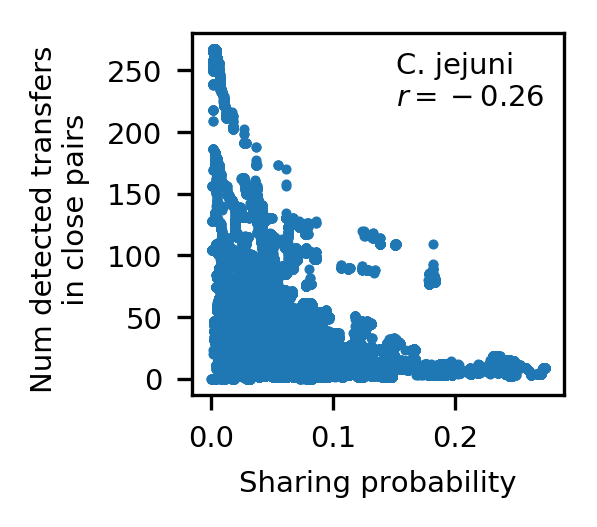

In [12]:
mpl.rcParams['font.size'] = 7
mpl.rcParams['lines.linewidth'] = 0.5
# mpl.rcParams['legend.frameon'] = False
mpl.rcParams['legend.fontsize'] = 'small'

fig, ax = plt.subplots(figsize=(1.6, 1.6), dpi=300)
ax.scatter(cumu_runs[:, 0], cp_pileup, s=2, rasterized=True)
ax.set_xlabel('Sharing probability')
ax.set_ylabel('Num detected transfers \n in close pairs')
corr = np.corrcoef(cumu_runs[:, 0], cp_pileup)[0, 1]
ax.text(0.55, 0.8, "C. jejuni \n$r={0:.2f}$".format(corr), transform=ax.transAxes,)
fig.savefig(os.path.join(config.figure_directory, 'isolates', 'Cj_pileup_cvs.pdf'), bbox_inches='tight')

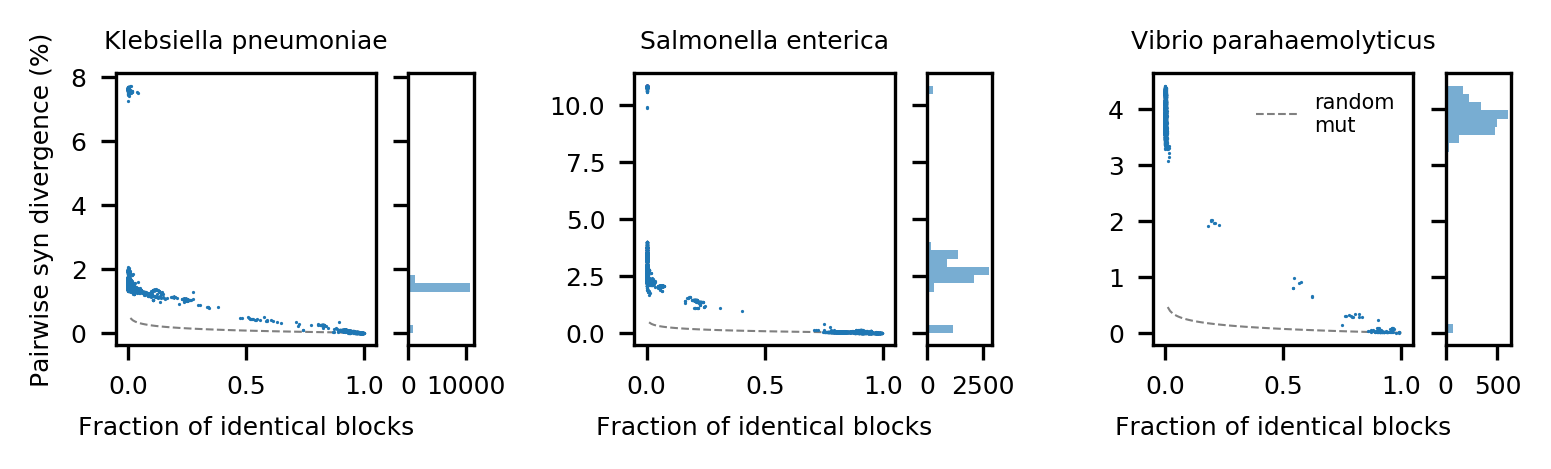

In [32]:
from utils import typical_pair_utils
import matplotlib.gridspec as gridspec
mpl.rcParams['font.size'] = 6
mpl.rcParams['lines.linewidth'] = 0.5
# mpl.rcParams['legend.frameon'] = False
mpl.rcParams['legend.fontsize'] = 'small'

species_to_plot = ['MGYG-HGUT-02538', 'MGYG-HGUT-02366', 'MGYG-HGUT-02331']
names = ['Klebsiella pneumoniae', 'Salmonella enterica', 'Vibrio parahaemolyticus']
fig, axes = plt.subplots(1, 3, figsize=(6, 1.2), dpi=300)
plt.subplots_adjust(wspace=0.45)
for i in range(3):
    ax = axes[i]
    inner_grid = gridspec.GridSpecFromSubplotSpec(1,2, width_ratios=[4,1],wspace=0.2,subplot_spec=ax)
    scatter_ax = fig.add_subplot(inner_grid[0])
    marg_ax = fig.add_subplot(inner_grid[1], sharey=scatter_ax)

    plt.setp(marg_ax.get_yticklabels(), visible=False)
    plt.setp(marg_ax.get_yticklabels(minor=True), visible=False)

    species_name = species_to_plot[i]
    x,y = typical_pair_utils.get_joint_plot_x_y(species_name)
    y = y * 100

    xs = np.linspace(0.01, 1, 100)
    ys = -np.log(xs) / config.first_pass_block_size * 100
    scatter_ax.plot(xs, ys, '--', color='grey', zorder=1, label='random\nmut', markersize=2)

    scatter_ax.scatter(x, y, s=0.6, linewidth=0, zorder=2, rasterized=True)
    marg_ax.hist(y, orientation='horizontal', bins=30, alpha=0.6)

    # marg_ax.set_xscale('log')
    if i==0:
        scatter_ax.set_ylabel('Pairwise syn divergence (%)')
    scatter_ax.set_xlabel('Fraction of identical blocks')
    scatter_ax.set_title(isolate_metadata.loc[species_name, 'Species'], fontsize=6)
    fig.delaxes(ax)
    
scatter_ax.legend(loc='best')
fig.savefig(os.path.join(config.figure_directory, 'isolates', 'pathogen_joint_dist.pdf'), bbox_inches='tight')

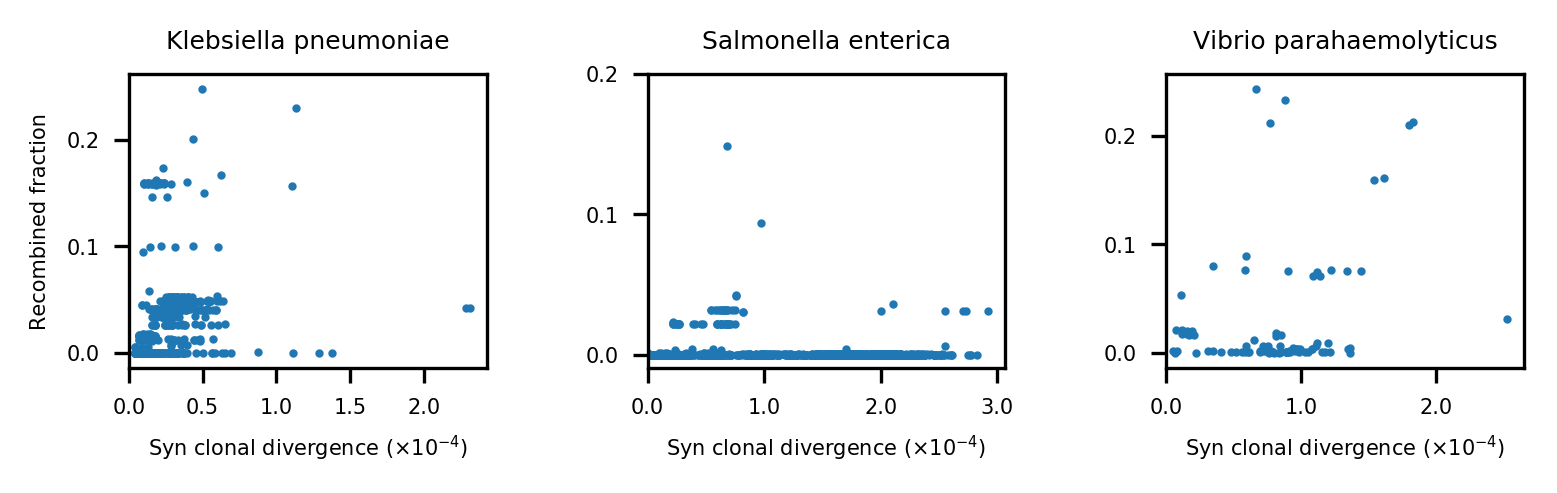

In [31]:
mpl.rcParams['font.size'] = 5
mpl.rcParams['lines.linewidth'] = 1
mpl.rcParams['legend.frameon'] = False
mpl.rcParams['legend.fontsize'] = 'small'

fig, axes = plt.subplots(1, 3, figsize=(6, 1.3), dpi=300)
plt.subplots_adjust(wspace=0.45)

species_to_plot = ['MGYG-HGUT-02538', 'MGYG-HGUT-02366', 'MGYG-HGUT-02331']
for i in range(3):
    species_name = species_to_plot[i]
    raw_data = pd.read_pickle(os.path.join(config.analysis_directory, 'closely_related', 'isolates', species_name + '_thirdpass.pickle'))
    x_, y_, cf_mask = close_pair_utils.prepare_x_y(raw_data, return_unfiltered=True, mode='fraction')
    x = x_[cf_mask]
    y = y_[cf_mask]

    axes[i].scatter(x, y, s=1)
    axes[i].set_xlim([0, max(x)*1.05])
    axes[i].set_yticks([0, 0.1, 0.2])
    axes[i].set_title(isolate_metadata.loc[species_name, 'Species'])
#     axes[i].ticklabel_format(axis='x', style='sci', scilimits=(0, 0))
    axes[i].set_xticklabels(["%.1f"%(x * 1e4) for x in axes[i].get_xticks()])
    axes[i].set_xlabel('Syn clonal divergence 'r'($\times 10^{-4}$)')
axes[0].set_ylabel("Recombined fraction")
fig.savefig(os.path.join(config.figure_directory, 'isolates', 'recomb_frac_pathogens.pdf'), bbox_inches='tight')

In [302]:
isolate_metadata

,Isolate counts,Family,Genera,Species,Type,Core genome length,4D synonymous site counts,Core to syn ratio
MGnify_accession,,,,,,,,
MGYG-HGUT-02478,101,Bacteroidaceae,Bacteroides,Bacteroides dorei,Gut commensal,1497264.0,208669.0,7.175306
MGYG-HGUT-01346,75,Bacteroidaceae,Bacteroides,Bacteroides uniformis,Gut commensal,1882855.0,284297.0,6.622845
MGYG-HGUT-02438,52,Tannerellaceae,Parabacteroides,Parabacteroides distasonis,Gut commensal,1961795.0,275548.0,7.119613
MGYG-HGUT-01337,45,Bacteroidaceae,Bacteroides,Bacteroides fragilis,Gut commensal,2101416.0,308464.0,6.812516
MGYG-HGUT-01378,41,Bacteroidaceae,Bacteroides,Bacteroides ovatus,Gut commensal,2385988.0,341031.0,6.996396
MGYG-HGUT-02492,36,Lachnospiraceae,NaN,[Eubacterium] rectale,Gut commensal,1189805.0,168997.0,7.040391
MGYG-HGUT-03681,27,Bacteroidaceae,Bacteroides,Bacteroides stercoris,Gut commensal,1018302.0,154944.0,6.572065
MGYG-HGUT-00196,23,Bacteroidaceae,Bacteroides,Bacteroides thetaiotaomicron,Gut commensal,202458.0,28579.0,7.084153
MGYG-HGUT-01345,21,Bacteroidaceae,Bacteroides,Bacteroides xylanisolvens,Gut commensal,1691740.0,241744.0,6.998064


# Prepare SI table

In [6]:
isolate_metadata = pd.read_csv(os.path.join(config.isolate_directory, 'isolate_info.csv'), index_col='MGnify_accession')

In [13]:
uhgg_metadata = pd.read_csv(os.path.join('/Volumes/Botein/uhgg', 'genomes-nr_metadata.tsv'), delimiter='\t')
uhgg_isolates = uhgg_metadata[uhgg_metadata['Genome_type']=='Isolate']

In [25]:
dfs = []
good_accessions = ['MGYG-HGUT-02478', 'MGYG-HGUT-01346', 'MGYG-HGUT-02438', 'MGYG-HGUT-01337', 'MGYG-HGUT-01378',
                  'MGYG-HGUT-02422', 'MGYG-HGUT-02538', 'MGYG-HGUT-02366', 'MGYG-HGUT-02331']
for accession in good_accessions:
    row = isolate_metadata.loc[accession, :]
    df = uhgg_isolates[uhgg_isolates['MGnify_accession']==accession]
    dfs.append(df)
    df['Species name'] = row['Species']
    df['Species type'] = row['Type']
big_df = pd.concat(dfs)

/Users/Device6/.pyenv/versions/2.7.18/envs/microbiome/lib/python2.7/site-packages/ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
/Users/Device6/.pyenv/versions/2.7.18/envs/microbiome/lib/python2.7/site-packages/ipykernel_launcher.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if __name__ == '__main__':


In [31]:
# Identify the last two columns
last_two_columns = big_df.columns[-2:]

# Create a new dataframe with reordered columns
new_columns = last_two_columns.append(big_df.columns[:-2])
new_df = big_df[new_columns].reset_index(drop=True)

In [33]:
new_df.to_csv(os.path.join(config.figure_directory, 'supp_table', 'isolate_metadata.csv'))

In [34]:
si_table = pd.read_csv(os.path.join(config.figure_directory, 'supp_table', 'isolate_metadata.csv'))